<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [13]</a>'.</span>

# Quality Control and ASV table construction with DADA2

## Setup and settings

In [1]:
# Importing packages
import os
import yaml
import logging
import pandas as pd
from qiime2 import Artifact
from qiime2 import Visualization
from qiime2 import Metadata
import qiime2.plugins.dada2.actions as dada2_actions
import qiime2.plugins.metadata.actions as metadata_actions
from qiime2.plugins.feature_table.visualizers import tabulate_seqs
from qiime2.plugins.feature_table.visualizers import summarize
from qiime2.plugins.feature_table.visualizers import core_features
from qiime2.plugins.feature_table.methods import filter_samples
from qiime2.plugins.feature_table.methods import filter_seqs

import matplotlib.pyplot as plt

%matplotlib inline

### Receiving the parameters

The following cell can receive parameters using the [papermill](https://papermill.readthedocs.io/en/latest/) tool.

In [2]:
experiment_name = 'ana-flavia-superlactacao'
base_dir = os.path.join('/', 'home', 'lauro', 'nupeb', 'redemicro')
metadata_file = os.path.join(base_dir, 'data', 'raw', 'metadata', 'sample-metadata.tsv')
manifest_file = os.path.join(base_dir, 'data', 'raw', 'manifest', 'sample-manifest.csv')
replace_files = False
phred = 20
trunc_f = 0
trunc_r = 0
overlap = 12
threads = 6
trim = None

In [3]:
# Parameters
experiment_name = "ana-flavia-all"
base_dir = "/home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri"
manifest_file = "/home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/data/raw/manifest-all-ana.csv"
metadata_file = "/home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/data/raw/metadata-all-ana.tsv"
class_col = "group-id"
classifier_file = "/home/lauro/nupeb/rede-micro/models/silva-138-99-nb-classifier.qza"
top_n = 20
replace_files = False
phred = 20
trunc_f = 0
trunc_r = 0
overlap = 12
threads = 6
trim = {
    "overlap": 8,
    "forward_primer": "CCTACGGGRSGCAGCAG",
    "reverse_primer": "GGACTACHVGGGTWTCTAAT",
}


In [4]:
# Setting hardcoded parameters for development and debbuging
production = True
if not production:
    params_path = os.path.join('..', 'params', 'ana-flavia-superlactacao.yaml')
    with open(params_path, 'r') as stream:
        params = yaml.safe_load(stream)
        experiment_name = params['experiment_name']
        base_dir = params['base_dir']
        replace_files = params['replace_files']
        experiment_folder = os.path.abspath(os.path.join(os.getcwd(), '..', 'experiments', 'thayane-feces-01'))
        img_folder = os.path.abspath(os.path.join(experiment_folder, 'imgs'))
        replace_files = False
        phred = 20
        trunc_f = 0
        trunc_r = 0
        overlap = 12
        threads = 6

In [5]:
experiment_folder = os.path.abspath(os.path.join(base_dir, 'experiments', experiment_name))
img_folder = os.path.abspath(os.path.join(experiment_folder, 'imgs'))
qiime_folder = os.path.join(experiment_folder, 'qiime-artifacts')
data_dir =  os.path.abspath(os.path.join(base_dir, 'data'))
raw_data_dir =  os.path.abspath(os.path.join(data_dir, 'raw'))
interim_data_dir =  os.path.abspath(os.path.join(data_dir, 'interim'))

### Defining names and paths

In [6]:
if trim:
    demux_file = os.path.join(qiime_folder, 'demux-paired-trim.qza')
else:
    demux_file = os.path.join(qiime_folder, 'demux-paired.qza')

dada2_tabs = os.path.join(qiime_folder, 'dada2-tabs.qza')
dada2_reps = os.path.join(qiime_folder, 'dada2-reps.qza')
dada2_stat = os.path.join(qiime_folder, 'dada2-stat.qza')


dada2_tabs_view = dada2_tabs[:-1] + 'v'
dada2_reps_view = dada2_reps[:-1] + 'v'
dada2_stat_view = dada2_stat[:-1] + 'v'
dada2_core_view = os.path.join(qiime_folder, 'dada2-core.qzv')

## Step execution

### Load input files

This Step import the QIIME2 `SampleData[PairedEndSequencesWithQuality]` Artifact with all demultiplexed sequences and the `Metadata` file.

In [7]:
need_dada2 = not (os.path.isfile(dada2_tabs) and os.path.isfile(dada2_reps) and os.path.isfile(dada2_stat)) or replace_files
need_view = not (os.path.isfile(dada2_tabs_view) and os.path.isfile(dada2_reps_view) and os.path.isfile(dada2_stat_view)) or replace_files

In [8]:
if need_dada2:
    demux = Artifact.load(demux_file)

In [9]:
metadata = Metadata.load(metadata_file)
metadata.to_dataframe().index

Index(['S210421121673', 'S210421121674', 'S210421121675', 'S210421121676',
       'S210421121677', 'S210421121678', 'S210421121679', 'S210421121680',
       'S210421121681', 'S210421121682', 'S210421121683', 'S210421121684',
       'S210421121685', 'S210421121686', 'S210421121687', 'S210421121688',
       'S210421121689', 'S210421121690', 'S210421121691', 'S210421121692',
       'S210421121693', 'S210421121694', 'S210421121695', 'S210421121696',
       'S210421121697', 'S210421121698', 'S210421121711', 'S210421121699',
       'S210421121700', 'S210421121701', 'S210421121702', 'S210421121703',
       'S210421121704', 'S210421121713', 'S210421121705', 'S210421121714',
       'S210421121706', 'S210421121707', 'S210421121708', 'S210421121709',
       'S210421121710'],
      dtype='object', name='sample-id')

In [10]:
# Determine if is SingleEnd or PairedEnd
manifest_df = pd.read_csv(manifest_file)
n_directions = len(manifest_df['direction'].unique())

### Execute DADA2 plugin and create Artifacts

The DADA2 plugin perform tha quality control and create the ASV table. It will be produced three Artifacts:

- tabs (`FeatureTable[Frequency]`) : 
    The resulting feature table.
- reps (`FeatureData[Sequence]`) :
    The resulting feature sequences. Each feature in the feature table will
    be represented by exactly one sequence, and these sequences will be the
    joined paired-end sequences.
- denoising_stats (`SampleData[DADA2Stats]`) : the resulting stats. Shows the number and the proportion of filtered reads in each phase of the plugin execution.

In [11]:
if not os.path.isfile(dada2_tabs) or replace_files:
    interim_tabs_path = os.path.join(interim_data_dir, "dada2-tabs.qza")
    interim_reps_path = os.path.join(interim_data_dir, "dada2-reps.qza")
    interim_stat_path = os.path.join(interim_data_dir, "dada2-stat.qza")
    # Verify if has shared files
    if os.path.isfile(interim_tabs_path) and os.path.isfile(interim_reps_path) and os.path.isfile(interim_stat_path):
        print("Load from shared data")
        tabs = Artifact.load(interim_tabs_path)
        reps = Artifact.load(interim_reps_path)
        stat = Artifact.load(interim_stat_path)
    # Create new DADA2 files
    else:
        print("Create new local data")
        if n_directions == 1: # SingleEnd
            tabs, reps, stat = dada2_actions.denoise_single(
                demultiplexed_seqs=demux,
                trunc_q = phred,
                n_threads = threads,
                trunc_len = trunc_f,
            )
        elif n_directions == 2: # PairedEnd
            tabs, reps, stat = dada2_actions.denoise_paired(
                demultiplexed_seqs=demux,
                trunc_q = phred,
                min_overlap = overlap,
                n_threads = threads,
                trunc_len_f = trunc_f,
                trunc_len_r = trunc_r,
            )
else:
    print("Load from local data")
    tabs = Artifact.load(dada2_tabs)
    reps = Artifact.load(dada2_reps)
    stat = Artifact.load(dada2_stat)

Load from shared data


In [12]:
A = set(metadata.to_dataframe().index)
B = set(tabs.view(pd.DataFrame).index)
len(B)

74

In [13]:
!ls -lah {dada2_tabs}

ls: cannot access '/home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-all/qiime-artifacts/dada2-tabs.qza': No such file or directory


In [14]:
tabs.save(dada2_tabs)
reps.save(dada2_reps)
stat.save(dada2_stat)

'/home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-all/qiime-artifacts/dada2-stat.qza'

In [15]:
# # If some of the DADA2 outputs artifacts do not exist or if the old files will be replaced
# if need_dada2:
    
#     # Excute the DADA2 plugin
#     if n_directions == 1: # SingleEnd
#         tabs, reps, stat = dada2_actions.denoise_single(
#             demultiplexed_seqs=demux,
#             trunc_q = phred,
#             n_threads = threads,
#             trunc_len = trunc_f,
#         )
#     elif n_directions == 2: # PairedEnd
#         tabs, reps, stat = dada2_actions.denoise_paired(
#             demultiplexed_seqs=demux,
#             trunc_q = phred,
#             min_overlap = overlap,
#             n_threads = threads,
#             trunc_len_f = trunc_f,
#             trunc_len_r = trunc_r,
#         )
    
#     # Save the artifacts objects
#     tabs.save(dada2_tabs)
#     reps.save(dada2_reps)
#     stat.save(dada2_stat)

# else:
#     tabs = Artifact.load(dada2_tabs)
#     reps = Artifact.load(dada2_reps)
#     stat = Artifact.load(dada2_stat)

### Filter samples

In [16]:
# Filter FeatureTable[Frequency | RelativeFrequency | PresenceAbsence | Composition] based on Metadata sample ID values
tabs = filter_samples(
    table=tabs,
    metadata=metadata,
).filtered_table
# Filter SampleData[SequencesWithQuality | PairedEndSequencesWithQuality | JoinedSequencesWithQuality] based on Metadata sample ID values; returns FeatureData[Sequence | AlignedSequence]
reps = filter_seqs(
    data=reps,
    table=tabs,
).filtered_data

{'min_frequency': 0, 'max_frequency': None, 'min_features': 0, 'max_features': None, 'metadata': Metadata
--------
41 IDs x 3 columns
sample-name: ColumnProperties(type='categorical')
group-id:    ColumnProperties(type='categorical')
group-desc:  ColumnProperties(type='categorical')

Call to_dataframe() for a tabular representation., 'where': None, 'exclude_ids': False, 'filter_empty_features': True, 'table': 2732 x 74 <class 'biom.table.Table'> with 12512 nonzero entries (6% dense)}
{'min_frequency': 0, 'max_frequency': None, 'min_features': 0, 'max_features': None, 'metadata': Metadata
--------
41 IDs x 3 columns
sample-name: ColumnProperties(type='categorical')
group-id:    ColumnProperties(type='categorical')
group-desc:  ColumnProperties(type='categorical')

Call to_dataframe() for a tabular representation., 'where': None, 'exclude_ids': False, 'filter_empty_features': True, 'table': 2732 x 74 <class 'biom.table.Table'> with 12512 nonzero entries (6% dense)}
{'metadata': None, 'wh

### Define Visualizations Artifacts

{'input': Metadata
--------
41 IDs x 1967 columns
c688e3b1ada46ed57f5b7e7e0d56664f: ColumnProperties(type='numeric')
bc798de4a9acd3ff7ba51c244523be14: ColumnProperties(type='numeric')
fca5b1ccd94b107a3ddf3e99feaafb6f: ColumnProperties(type='numeric')
5ba9e679e692fcbf933c554317e03c5f: ColumnProperties(type='numeric')
2f4a2b08eec8d8d5f66dc0d20552881f: ColumnProperties(type='numeric')
667c7a9ba435be56714ebcd4557f2a30: ColumnProperties(type='numeric')
31f232781685558bf9d62e35e8f237f9: ColumnProperties(type='numeric')
d7d3cdd53799e5296423251aa8f5cb20: ColumnProperties(type='numeric')
26fb6a43293a39fa4463bc35a69457b2: ColumnProperties(type='numeric')
ff6880f38ac8c1569873d503a3d53c2a: ColumnProperties(type='numeric')
55b8f708d3561852ca20801e513b08a7: ColumnProperties(type='numeric')
60ad690613589cad95c200968df41bb5: ColumnProperties(type='numeric')
77da8d8afe07e31d0a9647daf0ee90f7: ColumnProperties(type='numeric')
4149e7afc413d557b531ca78d17d8fe3: ColumnProperties(type='numeric')
b14c3f748ff5

{'input': Metadata
--------
1967 IDs x 1 column
Sequence: ColumnProperties(type='categorical')

Call to_dataframe() for a tabular representation., 'page_size': 100}
{'input': Metadata
--------
74 IDs x 8 columns
input:                             ColumnProperties(type='numeric')
filtered:                          ColumnProperties(type='numeric')
percentage of input passed filter: ColumnProperties(type='numeric')
denoised:                          ColumnProperties(type='numeric')
merged:                            ColumnProperties(type='numeric')
percentage of input merged:        ColumnProperties(type='numeric')
non-chimeric:                      ColumnProperties(type='numeric')
percentage of input non-chimeric:  ColumnProperties(type='numeric')

Call to_dataframe() for a tabular representation., 'page_size': 100}
{'sample_metadata': Metadata
--------
41 IDs x 3 columns
sample-name: ColumnProperties(type='categorical')
group-id:    ColumnProperties(type='categorical')
group-desc:  Colu

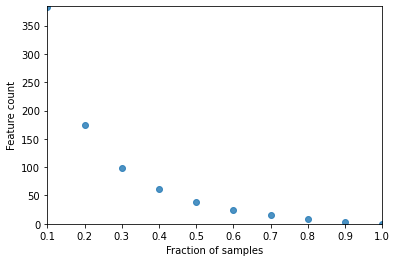

In [17]:
# If some of the DADA2 Visualization artifacts do not exist or if the old files will be replaced
if need_view:
    
    tabs_view, = metadata_actions.tabulate(input=tabs.view(Metadata))
    reps_view, = metadata_actions.tabulate(input=reps.view(Metadata))
    stat_view, = metadata_actions.tabulate(input=stat.view(Metadata))
    
    tabs_view = summarize(table=tabs, sample_metadata=metadata).visualization
    reps_view = tabulate_seqs(data=reps).visualization
    core_view = core_features(table=tabs, min_fraction=.1, steps=10).visualization
    
    
    # Save the artifacts objects
    tabs_view.save(dada2_tabs_view)
    reps_view.save(dada2_reps_view)
    stat_view.save(dada2_stat_view)
    core_view.save(dada2_core_view)

else:
    tabs_view = Visualization.load(dada2_tabs_view)
    reps_view = Visualization.load(dada2_reps_view)
    stat_view = Visualization.load(dada2_stat_view)
    core_view = Visualization.load(dada2_core_view)

In [18]:
def plot_stats_box(artifact, fname, total_reads_phases, percent_phases, cols):
    import matplotlib.pyplot as plt
    from qiime2 import Metadata
    
    df = artifact.view(Metadata).to_dataframe()
    df_vals = df[total_reads_phases]
    df_perc = df[percent_phases]
    df_perc.columns = cols
    
    
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    df_vals.boxplot()
    plt.xlabel('Fases')
    plt.ylabel('# of reads')
    
    plt.subplot(1, 2, 2)
    df_perc.boxplot()
    plt.xlabel('Fases')
    plt.ylabel('% of input')
    
    plt.savefig(fname, bbox_inches='tight')

    plt.show()

In [19]:
if n_directions == 1: # SingleEnd
    total_reads_phases = ['input', 'filtered', 'denoised', 'non-chimeric']
    percent_phases = ['percentage of input passed filter', 'percentage of input non-chimeric']
    cols = ['filtered', 'non-chimeric']
elif n_directions == 2: # PairedEnd
    total_reads_phases = ['input', 'filtered', 'denoised', 'merged', 'non-chimeric']
    percent_phases = ['percentage of input passed filter', 'percentage of input merged', 'percentage of input non-chimeric']
    cols = ['filtered', 'merged', 'non-chimeric']

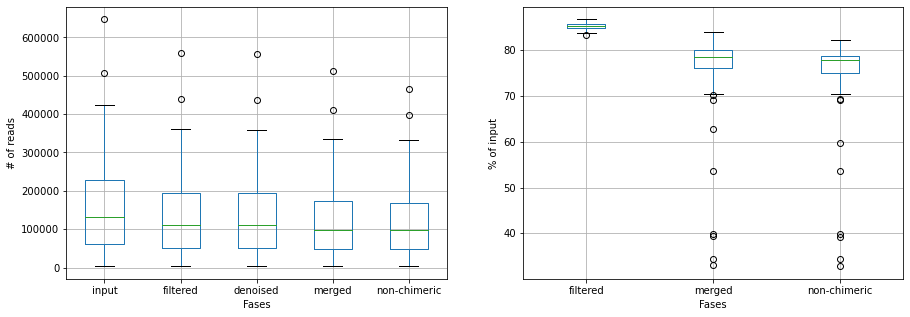

In [20]:
plot_stats_box(stat, os.path.join(img_folder, 'step02-stats-boxplot.pdf'), total_reads_phases, percent_phases, cols)

In [21]:
stat.view(Metadata).to_dataframe().describe()[percent_phases]

,percentage of input passed filter,percentage of input merged,percentage of input non-chimeric
count,74.000000,74.000000,74.000000
mean,85.240946,75.388649,74.583919
std,0.677259,10.290852,10.194336
min,83.410000,33.150000,32.760000
25%,84.822500,76.122500,74.970000
50%,85.220000,78.405000,77.895000
75%,85.662500,79.927500,78.760000
max,86.720000,83.920000,82.320000


In [22]:
stat_view

<visualization: Visualization uuid: b95329e5-83ca-4d4d-aad4-d942684b6a0f>

In [23]:
# new_stat = Artifact.load('/home/lauro/nupeb/redemicro/experiments/thayane-feces-01/qiime-artifacts/dada2-stat.qza')
# # new_view, = metadata_actions.tabulate(input=new_stat.view(Metadata))
# # plot_stats_box(old_stat)

# old_stat = Artifact.load('/home/lauro/nupeb/dados_brutos_rede_genoma/experiments/fezes-phred_20-tf_0-tr_0-lap_4/fezes_dada2_stat.qza')
# # old_view, = metadata_actions.tabulate(input=old_stat.view(Metadata))
# # plot_stats_box(old_stat)

# plot_stats_box_pairs(old_stat, new_stat)